In [1]:
import h5py
import os
import os.path
import numpy as np
import pandas as pd
import re
from pathlib import Path
from einops import rearrange
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from jiffy.decoder import DC2PriorDistribution
from jiffy.notebook_plotting_params import NoteBookPlottingParams

In [2]:
decoder_output_folder = Path("./decoder_output")
encoder_output_folder = Path("./encoder_output")
plotting_output_folder = Path("./plotting_output")
plotting_output_folder.mkdir(exist_ok=True)

n_params_per_model = 6
params_per_model = ["hlr", "e1", "e2", "flux", "dx", "dy"]

flux_cutoffs = [0.2, 0.4, 0.6, 0.8, 0.9]
mag_labels = ["< 23.9", "[23.9, 24.1]", "[24.1, 24.5]", 
              "[24.5, 24.9]", "[24.9, 25.6]", "> 25.6"]

In [3]:
def get_mag_label(raw_flux):
    flux_0_1 = (raw_flux - DC2PriorDistribution.FLUX_MIN) / DC2PriorDistribution.FLUX_SCALE
    flux_index = sum([flux_0_1 >= flux_cutoff for flux_cutoff in flux_cutoffs])
    mag_index = len(mag_labels) - flux_index - 1
    return mag_labels[mag_index]

In [4]:
encoder_output_files = [f for f in os.listdir(encoder_output_folder) 
                        if os.path.isfile(os.path.join(encoder_output_folder, f))]

In [5]:
class ParamsOneModel:
    def __init__(self, hlr, e1, e2, flux, dx, dy) -> None:
        self.hlr = hlr
        self.e1 = e1
        self.e2 = e2
        self.flux = flux
        self.dx = dx
        self.dy = dy

    def get_loc(self):
        return [self.dx, self.dy]
    
    def get_dict(self):
        return {"hlr": self.hlr,
                "e1": self.e1,
                "e2": self.e2,
                "flux": self.flux,
                "mag_bin": get_mag_label(self.flux),
                "dx": self.dx,
                "dy": self.dy}


class ParamsOneImage:
    def __init__(self, 
                 models: list[ParamsOneModel], 
                 file_name,
                 file_index) -> None:
        self.models = models
        self.file_name = file_name
        self.file_index = file_index

    def get_loc_matrix(self):
        return np.array([model.get_loc() for model in self.models])

    @classmethod
    def load_from_decoder_output_file(cls,
                                      decoder_output_csv_file_path):
        truth_file_name = os.path.basename(decoder_output_csv_file_path)
        truth_file_index_match = re.search(r'_(\d+)\.csv', truth_file_name)
        if truth_file_index_match:
            truth_file_index = int(truth_file_index_match.group(1))
        else:
            raise ValueError("can't find index in the file name")
        
        truth_df = pd.read_csv(decoder_output_csv_file_path)
        truth_df.drop(columns="nu", inplace=True)
        truth_dicts = truth_df.to_dict(orient="records")
        
        models = []
        for truth_dict in truth_dicts:
            models.append(ParamsOneModel(**truth_dict))

        return cls(models,
                   truth_file_name,
                   truth_file_index)

    @classmethod
    def load_from_encoder_output_file(cls, 
                                      encoder_output_file_path, 
                                      n_params_per_model, 
                                      params_per_model):
        output_file_name = os.path.basename(encoder_output_file_path)
        output_file_index_match = re.search(r'_(\d+)_seg0\.h5', output_file_name)
        if output_file_index_match:
            output_file_index = int(output_file_index_match.group(1))
        else:
            raise ValueError("can't find index in the file name")
        
        with h5py.File(encoder_output_file_path, "r") as f:
            group = f["Samples/footprint0"]
            param_names = group["post"].attrs["paramnames"]
            n_params = len(param_names)
            assert n_params % n_params_per_model == 0
            estimated_results = group["post"][...][-1]
            logprob = group["logprobs"][...][-1]

        max_logprob_indexes = np.argmax(logprob)
        best_params = estimated_results[max_logprob_indexes, ...].ravel()
        models = []
        for i in range(0, len(best_params), n_params_per_model):
            params_one_model = best_params[i : (i + n_params_per_model)]
            params_one_model_dict = {param_name: param_val 
                                    for param_name, param_val in zip(params_per_model, 
                                                                     params_one_model)}
            models.append(ParamsOneModel(**params_one_model_dict))
        return cls(models, output_file_name, output_file_index)

In [6]:
truth_image_params_list = []
est_image_params_list = []
for output_file in encoder_output_files:
    encoder_output_file_path = encoder_output_folder / output_file
    est_image_params = ParamsOneImage.load_from_encoder_output_file(
                                                    encoder_output_file_path, 
                                                    n_params_per_model,
                                                    params_per_model)
    est_image_params_list.append(est_image_params)
    truth_csv_file_path = decoder_output_folder / f"image_{est_image_params.file_index:04d}" / f"jiffy_decoder_image_{est_image_params.file_index:04d}.csv"
    truth_image_params = ParamsOneImage.load_from_decoder_output_file(truth_csv_file_path)
    truth_image_params_list.append(truth_image_params)

In [7]:
class JIFOutputDataset:
    def __init__(self, 
                 truth_image_params_list: list[ParamsOneImage],
                 est_image_params_list: list[ParamsOneImage]) -> None:
        self.truth_image_params_list = truth_image_params_list
        self.est_image_params_list = est_image_params_list

        self.truth_est_params_pair_list: list[tuple[ParamsOneModel, ParamsOneModel]] = []
        for truth, est in zip(self.truth_image_params_list,
                              self.est_image_params_list):
            truth_locs = truth.get_loc_matrix()
            est_locs = est.get_loc_matrix()
            truth_locs = rearrange(truth_locs, "i j -> i 1 j")
            est_locs = rearrange(est_locs, "i j -> 1 i j")
            locs_diff = truth_locs - est_locs
            cost = np.linalg.norm(locs_diff, ord=2, axis=2)

            row_indexes, col_indexes = linear_sum_assignment(cost)
            reordered_truth_models = [truth.models[row_index] 
                                      for row_index in row_indexes]
            reordered_est_models = [est.models[col_index]
                                    for col_index in col_indexes]
            self.truth_est_params_pair_list.extend(zip(reordered_truth_models,
                                                      reordered_est_models))

    def __iter__(self):
        return iter(self.truth_est_params_pair_list)
    
    def get_df(self):
        jif_output_dict = {col: [] for col in ["truth_flux", "truth_mag_bin", 
                                               "truth_hlr", "truth_e1", "truth_e2", "truth_dx", "truth_dy",
                                               "est_flux", "est_mag_bin", 
                                               "est_hlr", "est_e1", "est_e2", "est_dx", "est_dy"]}
        for truth_model_params, est_model_params in self:
            for k, v in truth_model_params.get_dict().items():
                jif_output_dict["truth_" + k].append(v)
            for k, v in est_model_params.get_dict().items():
                jif_output_dict["est_" + k].append(v)

        output_df = pd.DataFrame.from_dict(jif_output_dict)
        output_df["truth_mag_bin"] = pd.Categorical(output_df["truth_mag_bin"], 
                                                    categories=mag_labels, ordered=True)
        output_df["est_mag_bin"] = pd.Categorical(output_df["est_mag_bin"], 
                                                    categories=mag_labels, ordered=True)
        
        return output_df

In [8]:
jif_output_dataset = JIFOutputDataset(truth_image_params_list,
                                      est_image_params_list)

In [9]:
jif_output_df = jif_output_dataset.get_df()
jif_output_df.to_csv("./truth_est_df.csv")

In [10]:
jif_output_df["distance"] = np.sqrt((jif_output_df["truth_dy"] - jif_output_df["est_dy"]) ** 2 +
                                    (jif_output_df["truth_dx"] - jif_output_df["est_dx"]) ** 2)
jif_distance_quantile_results = jif_output_df.groupby("truth_mag_bin", observed=False)["distance"].quantile([0.2, 0.5, 0.8]).unstack()
jif_distance_quantile_results = jif_distance_quantile_results.sort_values("truth_mag_bin")

In [11]:
def plot_distance_quantile_results():
    x = np.array(list(range(len(mag_labels))))
    fig, ax = plt.subplots(1, 1,
                           figsize=NoteBookPlottingParams.figsize)
    ax.plot(x,
            jif_distance_quantile_results[0.5],
            "-o",
            color=NoteBookPlottingParams.color_dict["jif"])
    ax.fill_between(x,
                    jif_distance_quantile_results[0.2],
                    jif_distance_quantile_results[0.8],
                    color=NoteBookPlottingParams.color_dict["jif"],
                    alpha=0.4)
    ax.set_xlabel("Magnitude", fontsize=NoteBookPlottingParams.fontsize)
    ax.set_xticks(x)
    ax.set_xticklabels(mag_labels, rotation=45)
    ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
    ax.set_ylabel(r"Deviation from Truth ($arcsec^2$)", fontsize=NoteBookPlottingParams.fontsize)

    ax.grid(visible=True, axis="y")
    ax.grid(visible=False, axis="x")

    fig.tight_layout()

    return fig

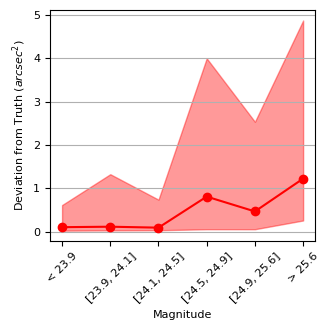

In [12]:
fig = plot_distance_quantile_results()
fig.savefig(plotting_output_folder / "distance.pdf", 
            bbox_inches="tight", 
            dpi=NoteBookPlottingParams.dpi)
fig.show()

In [13]:
def plot_acc():
    x = np.array(list(range(len(mag_labels))))
    mag_bin_counts = jif_output_df.groupby("truth_mag_bin", observed=False).size()
    fig, axes = plt.subplots(nrows=1, ncols=3,
                           figsize=(NoteBookPlottingParams.figsize[0] * 3,
                                    NoteBookPlottingParams.figsize[1]),
                            sharex="col", sharey="row")
    distance_cutoffs = [0.1, 0.5, 1.0]
    for i, distance_cutoff in enumerate(distance_cutoffs):
        distance_bin_data = jif_output_df.loc[jif_output_df["distance"] <= distance_cutoff]
        ax = axes[i]
        distance_bin_counts = distance_bin_data.groupby("truth_mag_bin", observed=False).size()
        ax.plot(x,
                [est_num / true_num 
                 for est_num, true_num in zip(distance_bin_counts, 
                                              mag_bin_counts, 
                                              strict=True)],
                "-o",
                color=NoteBookPlottingParams.color_dict["jif"])
        ax.set_xlabel("Magnitude", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_xticks(x)
        ax.set_xticklabels(mag_labels, rotation=45)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel("Detection Accuracy", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_title(f"Deviation less than {distance_cutoff} $arcsec^2$", fontsize=NoteBookPlottingParams.fontsize)
        ax.grid(visible=True, axis="y")
        ax.grid(visible=False, axis="x")

    fig.tight_layout()

    return fig

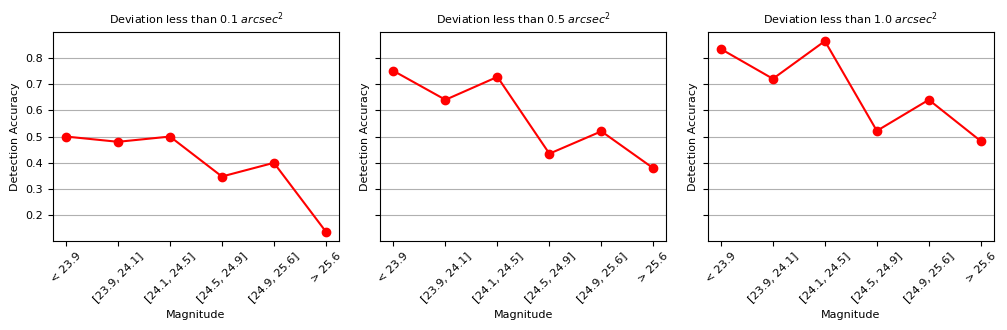

In [14]:
fig = plot_acc()
fig.savefig(plotting_output_folder / "acc.pdf", 
            bbox_inches="tight", 
            dpi=NoteBookPlottingParams.dpi)
fig.show()

In [15]:
jif_output_df["flux_residual_proportion"] = (jif_output_df["truth_flux"] - jif_output_df["est_flux"]) / jif_output_df["truth_flux"]

In [16]:
def plot_flux_residual_proportion():
    fig, ax = plt.subplots(1, 1,
                           figsize=NoteBookPlottingParams.figsize)
    jif_output_df.boxplot(column="flux_residual_proportion", 
                          by="truth_mag_bin", 
                          grid=False,
                          ax=ax)
    ax.set_xlabel("Magnitude", fontsize=NoteBookPlottingParams.fontsize)
    ax.set_xticklabels(mag_labels, rotation=45)
    ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
    ax.set_ylabel("Flux Residual Proportion", fontsize=NoteBookPlottingParams.fontsize)
    ax.set_title("")

    ax.grid(visible=True, axis="y")
    ax.grid(visible=False, axis="x")

    fig.suptitle("")
    fig.tight_layout()

    return fig

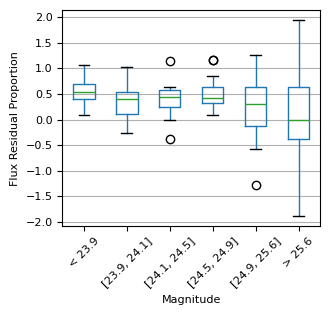

In [17]:
fig = plot_flux_residual_proportion()
fig.savefig(plotting_output_folder / "flux_residuals.pdf", 
            bbox_inches="tight", 
            dpi=NoteBookPlottingParams.dpi)
fig.show()

In [18]:
def plot_ellipticity(e_num):
    nrows = 3
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                           figsize=(NoteBookPlottingParams.figsize[0] * ncols,
                                    NoteBookPlottingParams.figsize[1] * nrows),
                            sharex="col", sharey="row")
    for i, mag_bin in enumerate(mag_labels):
        mag_bin_data = jif_output_df.loc[jif_output_df["truth_mag_bin"] == mag_bin]
        ax = axes[i % nrows, i // nrows]
        ax.scatter(mag_bin_data[f"truth_e{e_num}"],
                    mag_bin_data[f"est_e{e_num}"],
                    s=20.0,
                    alpha=0.6,
                    edgecolors="none",
                    color=NoteBookPlottingParams.color_dict["jif"])
        ax.axline([0, 0], [1, 1], color="grey", alpha=0.5)
        ax.set_title("Magnitude " + mag_bin, fontsize=NoteBookPlottingParams.fontsize)
        ax.grid(visible=True, axis="y")
        ax.grid(visible=True, axis="x")

        ax.set_xlabel(f"True $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel(f"Estimated $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)

        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)

    fig.tight_layout()

    return fig

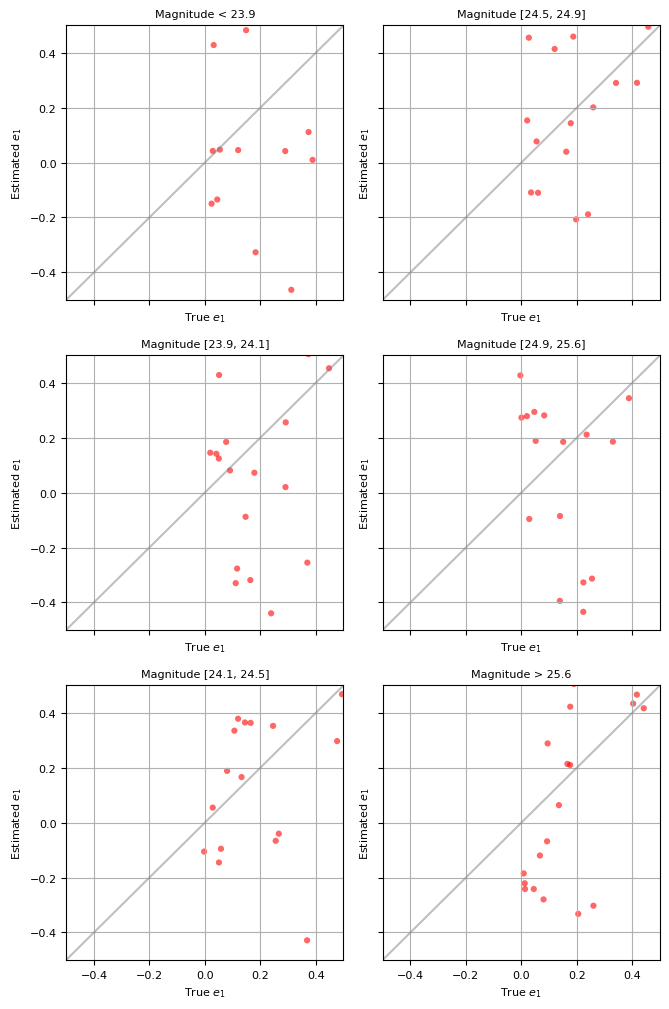

In [19]:
fig = plot_ellipticity(e_num=1)
fig.savefig(plotting_output_folder / "e1.pdf", 
            bbox_inches="tight", 
            dpi=NoteBookPlottingParams.dpi)
fig.show()

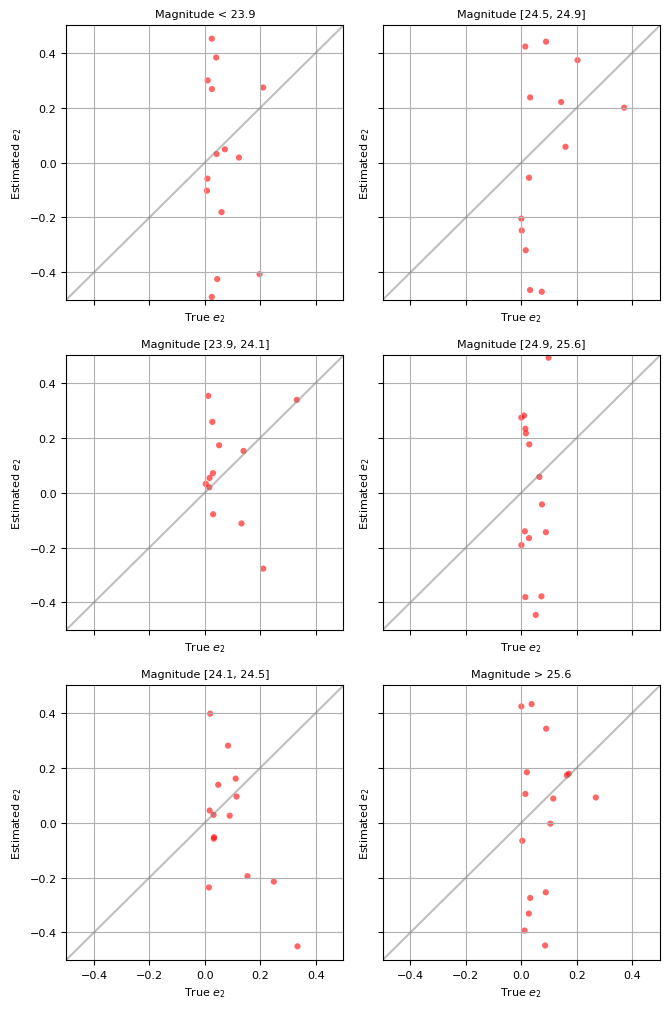

In [20]:
fig = plot_ellipticity(e_num=2)
fig.savefig(plotting_output_folder / "e2.pdf", 
            bbox_inches="tight", 
            dpi=NoteBookPlottingParams.dpi)
fig.show()